In [1]:
from __future__ import print_function

from instance import GGM_instance

from nbd_naive_and_ds import *

In [2]:
# TODO: Add root n to the randomization covariance
# Remark: Not needed (?) anymore since X is now scaled
prec,cov,X = GGM_instance(n=200,p=50, max_edges=1)
nbd_instance = nbd_lasso.gaussian(X, n_scaled=False,  weights_const=0.5,
                                  ridge_terms=1., randomizer_scale=1)
active_signs_nonrandom = nbd_instance.fit(perturb=np.zeros((50,49)))
active_signs_random = nbd_instance.fit()
print(active_signs_nonrandom.shape)
print(np.abs(active_signs_nonrandom).sum())
print(np.abs(active_signs_random).sum())
print(np.abs(prec != 0).sum() - 50)

(50, 49)
2.0
8.0
2


In [3]:
nonzero = get_nonzero(active_signs_nonrandom)

In [4]:
active_signs_nonrandom[1].shape

(49,)

In [6]:
def edge_inference(j0k0, S, n, p, var=None,
                   ngrid=10000):
    j0 = j0k0[0]
    k0 = j0k0[1]
    # n_total: the total data points in data splitting
    #        : the raw dimension of X in naive
    inner_prod = S[j0,k0]
    # print("inner_prod", "(", j0, ",", k0, "):" , inner_prod)
    # print("var:", var)

    S_copy = np.copy(S)

    #stat_grid = np.zeros((ngrid,))
    #print("n=100 assumed")
    stat_grid = np.linspace(-5,5,num=ngrid)
    def log_det_S_j_k(s_val):
        S_j_k = S_copy
        S_j_k[j0,k0] = s_val
        S_j_k[k0,j0] = s_val
        if np.linalg.det(S_j_k) < 0:
            print("negative det", np.linalg.det(S_j_k),
                  "grid", s_val)
            return -np.inf
        return np.log((np.linalg.det(S_j_k))) * (n-p-1)/2

    logWeights = np.zeros((ngrid,))
    for g in range(ngrid):
        logWeights[g] = log_det_S_j_k(stat_grid[g])

    # normalize logWeights
    logWeights = logWeights - np.max(logWeights)
    # Set extremely small values (< e^-500) to e^-500 for numerical stability
    # logWeights_zero = (logWeights < -500)
    # logWeights[logWeights_zero] = -500

    condlWishart = discrete_family(stat_grid, np.exp(logWeights),
                                   logweights=logWeights)

    neg_interval = condlWishart.equal_tailed_interval(observed=inner_prod,
                                                      alpha=0.1)
    if np.isnan(neg_interval[0]) or np.isnan(neg_interval[1]):
        print("Failed to construct intervals: nan")

    interval = invert_interval(neg_interval)

    pivot = condlWishart.ccdf(theta=0)

    return pivot, interval[0], interval[1], condlWishart, logWeights

In [7]:
def conditional_inference(X, nonzero):
    # X is divided by root n, where n is the dimension of X
    # The target of inference is n*Theta (n * prec)
    n,p = X.shape

    # Estimating variances by bootstrap
    # inner_vars = bootstrap_variance(X)
    S_ = X.T @ X
    # theta_h = np.linalg.inv(S_)
    intervals = np.zeros((p,p,2))
    # condlDists = {}
    for i in range(p):
        for j in range(i+1,p):
            if nonzero[i,j]:
                #S_ = X.T @ X
                #theta_h = np.linalg.inv(S_)
                # lcb, ucb are intervals for n * theta
                pivot, lcb, ucb, condlWishart, logWeights = edge_inference(j0k0=(i,j), S=S_, n=n, p=p, ngrid=10000)
                #pivot, lcb, ucb = edge_inference_scipy(j0=i, k0=j, S=S_,
                 #                                      n=n, p=p, Theta_hat=theta_h)
                # interval = invert_interval(neg_int, scalar=n)
                intervals[i,j,0] = lcb/n
                intervals[i,j,1] = ucb/n
                # print("(", i, ",", j, "): (", lcb/n, ",", ucb/n, ")")
                if ucb/n - lcb/n < 0.01:
                    print("WARNING: SHORT INTERVAL")

    return intervals#, condlDists

In [8]:
def data_splitting(X, prec, weights_const=1., proportion=0.5, parallel=False,
                   seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Precision matrix is in its original order, not scaled by root n
    # X is also in its original order
    n,p = X.shape
    pi_s = proportion
    subset_select = np.zeros(n, np.bool_)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)

    # Rescale X_S and X_NS for numerical stability
    X_S = X[subset_select, :] / np.sqrt(n1)
    X_NS = X[~subset_select, :] / np.sqrt(n2)

    nbd_instance = nbd_lasso.gaussian(X_S, n_scaled=True, weights_const=weights_const)
    active_signs_nonrandom = nbd_instance.fit(perturb=np.zeros((p,p-1)))
    nonzero = get_nonzero(active_signs_nonrandom)
    # print("Data Splitting |E|:", nonzero.sum())

    # Construct intervals
    if nonzero.sum() > 0:
        # Intervals returned is in its original (unscaled) order
        # intervals, condlDists = conditional_inference(X_NS, nonzero=nonzero)
        intervals = conditional_inference(X_NS, nonzero=nonzero)
        # coverage is upper-triangular
        coverage = get_coverage(nonzero, intervals, prec * n2, n2, p)
        interval_len = 0
        nonzero_count = 0
        for i in range(p):
            for j in range(i+1,p):
                if nonzero[i,j]:
                    interval = intervals[i,j,:]
                    interval_len = interval_len + (interval[1] - interval[0])
                    nonzero_count = nonzero_count + 1
        avg_len = interval_len / nonzero_count
        cov_rate = coverage.sum() / nonzero_count
        return nonzero, intervals, cov_rate, avg_len
    return None, None, None, None

In [9]:
nonzero, intervals, cov_rate, avg_len = data_splitting(X, prec,
                                                       proportion = 0.5,
                                                       parallel=False,
                                                       weights_const=0.5)

In [10]:
def print_nonzero_intervals(nonzero, intervals, prec, X):
    # Intervals, prec, X are all in their original scale
    n, p = X.shape
    S = X.T @ X / n
    Theta_hat = np.linalg.inv(S)

    for i in range(p):
        for j in range(i+1,p):
            if nonzero[i,j]:
                print("(",i,",",j,")", "selected")
                print("Theta", "(",i,",",j,")", "interval:", intervals[i,j,:])
                print("Theta", "(",i,",",j,")", prec[i,j])
                print("S", "(",i,",",j,")", S[i,j])
                print("Theta_hat", "(",i,",",j,")", Theta_hat[i,j])
print_nonzero_intervals(nonzero, intervals, prec, X)

TypeError: 'NoneType' object is not subscriptable

In [10]:
n=500
p=50
for i in range(p):
    for j in range(i + 1, p):
        if nonzero[i, j]:
            print("(i,j) = (", i, ",", j, ")")
            print("Theta", prec[i, j])

(i,j) = ( 32 , 35 )
Theta -0.18877451387947886


In [227]:
n,p = X.shape
pi_s = 0.5
subset_select = np.zeros(n, np.bool_)
subset_select[:int(pi_s * n)] = True
n1 = subset_select.sum()
n2 = n - n1
np.random.shuffle(subset_select)

# Rescale X_S and X_NS for numerical stability
X_S = X[subset_select, :] / np.sqrt(n1)
X_NS = X[~subset_select, :] / np.sqrt(n2)

S_ = X_NS.T @ X_NS

pivot, lcb, ucb, condlWishart, logWeights = \
    edge_inference(j0k0=(10,49), S=S_, n=n, p=p, ngrid=10000)

negative det -1.7184286571269072 grid -5.0
negative det -1.7177008460176566 grid -4.998999899989999
negative det -1.7169731801822883 grid -4.997999799979998
negative det -1.7162456596208113 grid -4.996999699969997
negative det -1.7155182843332069 grid -4.995999599959996
negative det -1.7147910543194924 grid -4.994999499949995
negative det -1.7140639695796578 grid -4.993999399939994
negative det -1.7133370301137072 grid -4.992999299929993
negative det -1.7126102359216437 grid -4.991999199919992
negative det -1.7118835870034632 grid -4.990999099909991
negative det -1.7111570833591618 grid -4.98999899989999
negative det -1.710430724988745 grid -4.988998899889989
negative det -1.7097045118922143 grid -4.987998799879988
negative det -1.708978444069567 grid -4.986998699869987
negative det -1.7082525215208024 grid -4.985998599859986
negative det -1.7075267442459225 grid -4.9849984998499846
negative det -1.7068011122449214 grid -4.983998399839984
negative det -1.7060756255178107 grid -4.982998

In [229]:
print(lcb, ucb)
print(prec[10,49]*1000)

-504.92555222277474 -388.9642172664944
-492.7133294227815


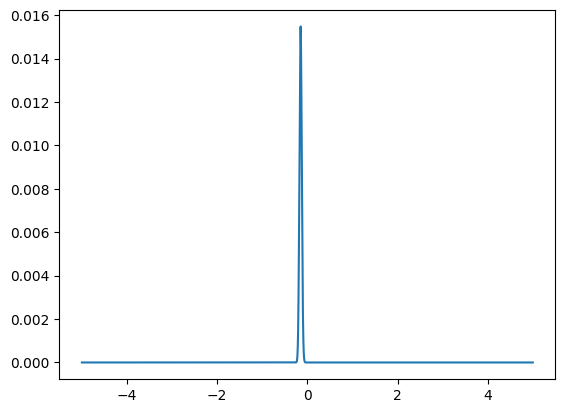

In [225]:
grid = np.linspace(-5, 5, num=10000)
condlWishart.theta=-250
plt.plot(grid,condlWishart._pdf)

array([1.48268562e-05, 4.01893850e-05, 1.02028324e-04, 2.42859010e-04,
       5.42590092e-04, 1.13898387e-03, 2.24863885e-03, 4.17918558e-03,
       7.31867432e-03, 1.20872407e-02, 1.88428998e-02, 2.77493704e-02,
       3.86358064e-02, 5.08970928e-02, 6.34870726e-02, 7.50376155e-02,
       8.40960262e-02, 8.94263705e-02, 9.02880629e-02, 8.66045840e-02,
       7.89694392e-02, 6.84916410e-02, 5.65353817e-02, 4.44367889e-02,
       3.32760401e-02, 2.37523308e-02, 1.61687939e-02, 1.05014529e-02,
       6.51055047e-03, 3.85453132e-03, 2.18018322e-03, 1.17857474e-03,
       6.09161611e-04, 3.01148872e-04, 1.42448869e-04, 6.44934171e-05,
       2.79572159e-05, 1.16073276e-05, 4.61702495e-06, 1.75998956e-06,
       6.43126718e-07, 2.25339270e-07, 7.57253083e-08, 2.44125871e-08,
       7.55187477e-09, 2.24211851e-09, 6.39020516e-10, 1.74867163e-10,
       4.59535344e-11, 1.15990390e-11, 2.81247135e-12, 6.55214019e-13,
       1.46679240e-13, 3.15574161e-14, 6.52580379e-15, 1.29722241e-15,
      

In [176]:
S_ = X_NS.T @ X_NS
Theta_hat = np.linalg.inv(S_)
interval = condlWishart.equal_tailed_interval(observed=Theta_hat[26,47], alpha=0.1)

In [177]:
print(interval[0]/500, interval[1]/500)

-0.3877497404236036 -0.24818579721778147


In [178]:
print(condlWishart._lw)

[-8.98433338e+01 -8.68259690e+01 -8.38741194e+01 -8.09866868e+01
 -7.81626117e+01 -7.54008720e+01 -7.27004815e+01 -7.00604881e+01
 -6.74799733e+01 -6.49580501e+01 -6.24938623e+01 -6.00865833e+01
 -5.77354150e+01 -5.54395866e+01 -5.31983541e+01 -5.10109988e+01
 -4.88768270e+01 -4.67951687e+01 -4.47653771e+01 -4.27868275e+01
 -4.08589173e+01 -3.89810645e+01 -3.71527076e+01 -3.53733045e+01
 -3.36423326e+01 -3.19592875e+01 -3.03236831e+01 -2.87350505e+01
 -2.71929381e+01 -2.56969107e+01 -2.42465491e+01 -2.28414502e+01
 -2.14812257e+01 -2.01655026e+01 -1.88939221e+01 -1.76661401e+01
 -1.64818259e+01 -1.53406626e+01 -1.42423466e+01 -1.31865873e+01
 -1.21731066e+01 -1.12016393e+01 -1.02719320e+01 -9.38374350e+00
 -8.53684449e+00 -7.73101714e+00 -6.96605502e+00 -6.24176294e+00
 -5.55795678e+00 -4.91446327e+00 -4.31111992e+00 -3.74777483e+00
 -3.22428658e+00 -2.74052410e+00 -2.29636656e+00 -1.89170331e+00
 -1.52643370e+00 -1.20046708e+00 -9.13722677e-01 -6.66129562e-01
 -4.57626554e-01 -2.88162

In [175]:
def edge_inference_scipy(j0, k0, S, n, p, Theta_hat=None, var=None, level=0.9, ngrid=10000):
    # n_total: the total data points in data splitting
    #        : the raw dimension of X in naive
    inner_prod = S[j0,k0]

    # Theta_hat: A low dimensional point estimate of theta
    if Theta_hat is None:
        t_j_k = - inner_prod * n
    else:
        t_j_k = Theta_hat[j0,k0] * n
    print(t_j_k)

    def log_det_S_j_k(s_val):
        S_j_k = S
        S_j_k[j0,k0] = s_val
        S_j_k[k0,j0] = s_val
        return np.log(np.abs(np.linalg.det(S_j_k))) * (n-p-1)/2
    def det_S_j_k(s_val):
        return np.exp(log_det_S_j_k(s_val))

    """def get_logdet_normalizer():
        sparse_grid = np.linspace(-2, 2, num=100)
        sparse_log_det = np.zeros((ngrid,))
        for g in range(100):
            sparse_log_det[g] = log_det_S_j_k(sparse_grid[g])
        log_det_normalizer = np.max(sparse_log_det)
        return log_det_normalizer

    ldn = get_logdet_normalizer()
    print("ldn", np.exp(ldn))
    # normalized determinant by multiplying 1/det_S_j_k(0)

    def det_S_j_k_nomalized(s_val, log_normalizer=0):
        return np.exp(log_det_S_j_k(s_val) - np.log(det_S_j_k(0)))"""

    def condl_pdf(t,theta=0):
        return det_S_j_k(t) * np.exp(-theta*t)

    def condl_log_pdf(t,theta=0):
        return log_det_S_j_k(t) - theta * t

    def get_pivot(theta0=0):
        # Normalize the pdf by the maximum over a sparse grid
        def get_pdf_log_normalizer(theta0):
            sparse_grid = np.linspace(-2, 2, num=100)
            sparse_lpdf = np.zeros((ngrid,))
            for g in range(100):
                sparse_lpdf[g] = condl_log_pdf(sparse_grid[g],theta0)
            pdf_log_normalizer = np.max(sparse_lpdf)

            if pdf_log_normalizer > 100:
                pdf_log_normalizer /= 10
            return pdf_log_normalizer

        pdfln = get_pdf_log_normalizer(theta0)
        #print("pdfln", pdfln)
        # Normalized pdf
        def condl_pdf_normalized(t, theta=0):
            return det_S_j_k(t) * np.exp(-theta*t - pdfln)

        grid_lb = -1
        grid_ub = 1
        normalizer = quad(condl_pdf_normalized,
                          grid_lb,
                          grid_ub, args=(theta0,))[0]
        #print(normalizer)

        cdf_upper = quad(condl_pdf_normalized, inner_prod, grid_ub,
                         args=(theta0,))[0] / normalizer

        """stat_grid = np.zeros((1, ngrid))

        stat_grid[0,:] = np.linspace(grid_lb,
                                     grid_ub,
                                     num=ngrid)
        density = np.zeros((ngrid,))
        logdet = np.zeros((ngrid,))
        for g in range(ngrid):
            density[g] = condl_pdf_normalized(stat_grid[0,g], theta0)
            logdet[g] = det_S_j_k(stat_grid[0,g])

        plt.plot(stat_grid[0,:], density)
        plt.figure(2)
        plt.plot(stat_grid[0,:], logdet)"""
        return cdf_upper

    pivot = get_pivot(0)

    def get_pivot_val(x,val=0.99):
        return get_pivot(x) - val

    print("bracket", t_j_k-0.2*n,t_j_k+0.2*n)

    # Construct CI
    margin = (1 - level) / 2
    """root_low = root_scalar(get_pivot_val, bracket=[t_j_k-0.1*n,t_j_k+0.3*n], args=(margin,),
                           method='bisect')
    root_up = root_scalar(get_pivot_val, bracket=[t_j_k-0.3*n,t_j_k+0.1*n], args=(1 - margin,),
                           method='bisect')"""
    root_low = find_root(f=get_pivot, y=margin, lb=t_j_k-0.1*n, ub=t_j_k+0.3*n, tol=1e-6)
    root_up = find_root(f=get_pivot, y=1-margin, lb=t_j_k-0.3*n, ub=t_j_k+0.1*n, tol=1e-6)

    return pivot, root_up, root_low

In [6]:
# Precision matrix is in its original order, not scaled by root n
# X is also in its original order
n,p = X.shape
pi_s = proportion = 0.67
subset_select = np.zeros(n, np.bool_)
subset_select[:int(pi_s * n)] = True
n1 = subset_select.sum()
n2 = n - n1
np.random.shuffle(subset_select)

# Rescale X_S and X_NS for numerical stability
X_S = X[subset_select, :] / np.sqrt(n1)
X_NS = X[~subset_select, :] / np.sqrt(n2)

nbd_instance = nbd_lasso.gaussian(X_S, n_scaled=True)
active_signs_nonrandom = nbd_instance.fit(perturb=np.zeros((p,p-1)))
nonzero = get_nonzero(active_signs_nonrandom)
# print("Data Splitting |E|:", nonzero.sum())

for i in range(p):
    for j in range(i+1,p):
        if nonzero[i,j]:
            print("(i,j) = (",i,",",j,")")
            print("Theta", prec[i,j])

"""# Construct intervals
if nonzero.sum() > 0:
    # Intervals returned is in its original (unscaled) order
    # intervals, condlDists = conditional_inference(X_NS, nonzero=nonzero)
    intervals = conditional_inference(X_NS, nonzero=nonzero)
    # coverage is upper-triangular
    coverage = get_coverage(nonzero, intervals, prec * n2, n2, p)
    interval_len = 0
    nonzero_count = 0
    for i in range(p):
        for j in range(i+1,p):
            if nonzero[i,j]:
                interval = intervals[i,j,:]
                interval_len = interval_len + (interval[1] - interval[0])
                nonzero_count = nonzero_count + 1
    avg_len = interval_len / nonzero_count
    cov_rate = coverage.sum() / nonzero_count"""

Custom perturbation
(i,j) = ( 5 , 9 )
Theta 0.28070579437147164


'# Construct intervals\nif nonzero.sum() > 0:\n    # Intervals returned is in its original (unscaled) order\n    # intervals, condlDists = conditional_inference(X_NS, nonzero=nonzero)\n    intervals = conditional_inference(X_NS, nonzero=nonzero)\n    # coverage is upper-triangular\n    coverage = get_coverage(nonzero, intervals, prec * n2, n2, p)\n    interval_len = 0\n    nonzero_count = 0\n    for i in range(p):\n        for j in range(i+1,p):\n            if nonzero[i,j]:\n                interval = intervals[i,j,:]\n                interval_len = interval_len + (interval[1] - interval[0])\n                nonzero_count = nonzero_count + 1\n    avg_len = interval_len / nonzero_count\n    cov_rate = coverage.sum() / nonzero_count'

In [30]:
S=X_NS.T @ X_NS
theta_hat = np.linalg.inv(S)
pivot, lcb, ucb = edge_inference_scipy(j0=0,k0=5,S=S,n=n2,p=p,Theta_hat=theta_hat)

-92.21428786134462
bracket -158.21428786134462 -26.214287861344616


In [31]:
lcb/n2, ucb/n2

(-0.3712540516773781, -0.17657569741407247)

In [144]:
print(np.linalg.inv(np.asarray([[1, 0.9, 0],
                                [0.9, 1, 0],
                                [0, 0, 1]])))

[[ 5.26315789 -4.73684211  0.        ]
 [-4.73684211  5.26315789  0.        ]
 [ 0.          0.          1.        ]]


In [83]:
def print_nonzero_intervals(nonzero, intervals, prec, X):
    # Intervals, prec, X are all in their original scale
    n, p = X.shape
    S = X.T @ X / n

    for i in range(p):
            for j in range(i+1,p):
                if nonzero[i,j]:
                    print("(",i,",",j,")", "selected")
                    print("Theta", "(",i,",",j,")", "interval:", intervals[i,j,:])
                    print("Theta", "(",i,",",j,")", prec[i,j])
                    print("S/n", "(",i,",",j,")", S[i,j])
print_nonzero_intervals(nonzero, intervals, prec, X)

( 3 , 7 ) selected
Theta ( 3 , 7 ) interval: [0.20787315 0.38201774]
Theta ( 3 , 7 ) 0.0
S/n ( 3 , 7 ) -0.002432089772410599
